In [ ]:
#create image classification model
#first create an image dataset with correct labelling
#load batches of data samples in pytorch and use cleaned images dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
import random
import torch.optim as optim
import torch.nn.functional as F

/home/shah/miniconda3/envs/selenium_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ProductImageCategoryDataset():
    def __init__(self, learning_rate = 1e-3):
        super().__init__()
        self.X = pd.read_pickle('data/image_model_X.pkl')
        #self.X['image_array'] = self.X.values.tolist()
        #self.X = self.X['image_array']
        self.y = pd.read_pickle('data/image_model_y.pkl')
        #print(train_X.shape)
        #print(len(self.X))
        #print(len(self.y))
        assert len(self.X) == len(self.y)

    def __getitem__(self, index):
        features = self.X.iloc[index]
        label = self.y.iloc[index]
        #print(index)
        features = torch.tensor(features).float()
        #3=num of batch(get 3 images at every iteration of training the network)
        features = features.reshape(3, 64, 64)
        #print(features.shape)
        label = int(label)
        
        return (features, label)
    
    def __len__(self):
        return len(self.X)

dataset = ProductImageCategoryDataset()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(len(dataset))
#dataset[12667]
#for idx in range(len(dataset)):
    #example = dataset[idx]
    #features, label = example
    #print(features.shape)
    #print(label)
  #  break

In [3]:
random_seed = 42
test_split_size = 0.2
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_size * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)



In [4]:
train_loader = {
    'train' : torch.utils.data.DataLoader(dataset, batch_size=16, sampler=train_sampler, num_workers=1),
    'test' : torch.utils.data.DataLoader(dataset, batch_size=16, sampler=test_sampler, num_workers=1)
}

images-size: torch.Size([16, 3, 64, 64])
out-size: torch.Size([3, 134, 530])


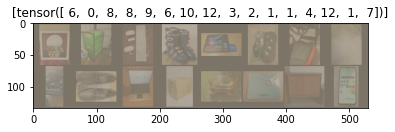

In [13]:
def imshow(inp, title=None):
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, label = next(iter(train_loader['train'])) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[label])

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #self.layers = torch.nn.Sequential(
            #3 input image channels, 8 output channels,
            #9x9 square convolution kernel
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
            #Max pooling over a (2, 2) window, #kernel and stride=2
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
            #torch.nn.Flatten(), #flatten
        self.fc1 = torch.nn.Linear(2704, 120) #simplifiy further with linear layers - output channel((128-5)/1+1) = 124, 124/2=62 so 62*62*6=23064
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 14)
        torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = Optimizer = optim.Adadelta(model.parameters(), lr=0.001)



In [ ]:
from torchsummary import summary
model = torchvision.models.resnet50(pretrained=True)
summary(model, (3, 128, 128))

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
            #3 input image channels, 8 output channels,
            #9x9 square convolution kernel
            torch.nn.Conv2d(in_channels=3,  out_channels=6, kernel_size=(5,5)), 
            torch.nn.ReLU(inplace=True),
            #Max pooling over a (2, 2) window, #kernel and stride=2
            torch.nn.MaxPool2d(kernel_size=(2, 2)),
            torch.nn.Conv2d(6, 16, 5),
            torch.nn.Flatten(), #flatten
            torch.nn.Linear(23064, 120), #simplifiy further with linear layers - output channel((128-5)/1+1) = 124, 124/2=62 so 62*62*6=23064
            torch.nn.Linear(),
            torch.nn.Linear()
            torch.nn.Softmax(dim=1)
 ) #turn into probabilities

In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = Optimizer = optim.Adadelta(model.fc.parameters(), lr=0.001)

In [7]:
#Train the model
num_epochs = 10
total_step = len(train_loader['train'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_loader['train']):
        
        features, label = batch
        #features = features.to(device)
        #label = label.to(device)

        outputs = model(features)
        loss = criterion(outputs, label)

   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if (i+1) % 100 == 0:
                print('Epoch [{}/{}, Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    #print('{} loss: {: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
print(outputs)

Epoch [1/10, Step [100/619], Loss: 2.6415
Epoch [1/10, Step [200/619], Loss: 2.6156
Epoch [1/10, Step [300/619], Loss: 2.6436
Epoch [1/10, Step [400/619], Loss: 2.6351
Epoch [1/10, Step [500/619], Loss: 2.6635
Epoch [1/10, Step [600/619], Loss: 2.6424
Epoch [2/10, Step [100/619], Loss: 2.6285
Epoch [2/10, Step [200/619], Loss: 2.6688
Epoch [2/10, Step [300/619], Loss: 2.6283
Epoch [2/10, Step [400/619], Loss: 2.6220
Epoch [2/10, Step [500/619], Loss: 2.6556
Epoch [2/10, Step [600/619], Loss: 2.6571
Epoch [3/10, Step [100/619], Loss: 2.6521
Epoch [3/10, Step [200/619], Loss: 2.6458
Epoch [3/10, Step [300/619], Loss: 2.6441
Epoch [3/10, Step [400/619], Loss: 2.6149
Epoch [3/10, Step [500/619], Loss: 2.6430
Epoch [3/10, Step [600/619], Loss: 2.6519
Epoch [4/10, Step [100/619], Loss: 2.6458
Epoch [4/10, Step [200/619], Loss: 2.6222
Epoch [4/10, Step [300/619], Loss: 2.6384
Epoch [4/10, Step [400/619], Loss: 2.6356
Epoch [4/10, Step [500/619], Loss: 2.6644
Epoch [4/10, Step [600/619], Loss:

In [11]:
#test the model
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for batch in train_loader['test']:
            features, label = batch
            test_output = model(features)
            last_layer = test_output
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == label).sum().item() / float(label.size(0))
    print('Test Accuracy of the model on the test images: %.2f' % accuracy)
    pass

Test Accuracy of the model on the test images: 0.30
